In [33]:
# SET CONFIG AND PARAMETERS
path = '/home/xilinx/jupyter_notebooks/qick/TII/characterizationScripts/zcu216/configuration/'
with open(path+"setConfigV1.py", 'r') as f:
    code1 = f.read()
    exec(code1)
with open(path+"setParametersSpinq10q69.py", 'r') as f:
    code2 = f.read()
    exec(code2) 

Configuration and paramiters set


In [34]:
class ChevronsSweeperProgram(NDAveragerProgram):
    
    def ns2cycles(self, ns, gen_ch=None, ro_ch=None):
        return self.us2cycles(ns/1000, gen_ch=gen_ch, ro_ch=ro_ch)

    def initialize(self):
        cfg=self.cfg
        sweeps=[]
        probe_ch    = cfg["probe_ch"]        
        feedback_ch = cfg["feedback_ch"]        
        ro_pulse_shape  = cfg["ro_pulse_shape"]
        ro_pulse_length = self.ns2cycles(cfg["ro_pulse_length"], gen_ch=probe_ch)  
        self.declare_gen(ch=probe_ch, 
                         nqz=cfg["probe_ch_nqz"], 
                         mux_freqs=self.cfg['ro_pulse_frequency'], 
                         mux_gains=self.cfg['ro_pulse_gain'])
        self.set_pulse_registers(ch=probe_ch, 
                                 style=ro_pulse_shape, 
                                 length=ro_pulse_length, 
                                 mask=[0,1,2,3])        
        for iCh, ch in enumerate(feedback_ch):
            self.declare_readout(ch=ch, 
                                 freq=self.cfg['acquisition_frequency'][iCh], 
                                 length = self.ns2cycles(self.cfg['acquisition_length'], ro_ch=ch), 
                                 gen_ch=probe_ch)  
        
      
        
        q2_drive_ch = cfg["q2_drive_ch"]
        q2_drive_pulse_DAC_frequency = self.freq2reg(cfg["q2_drive_pulse_frequency"], gen_ch=q2_drive_ch)
        q2_drive_pulse_DAC_phase     = self.deg2reg(cfg["q2_drive_pulse_relative_phase"], gen_ch=q2_drive_ch)
        q2_drive_pulse_DAC_gain      = int(cfg["q2_drive_pulse_gain"] * MAX_GAIN)
        q2_drive_pulse_shape         = cfg["q2_drive_pulse_shape"]
        q2_drive_pulse_length        = self.ns2cycles(cfg["q2_drive_pulse_length"], gen_ch=q2_drive_ch)   
        self.declare_gen(ch=q2_drive_ch, 
                         nqz=cfg["drive_ch_nqz"])
        self.add_gauss(ch=q2_drive_ch, 
                       name="drive_pulse", 
                       sigma=int(cfg["sigma_2"] * 384), 
                       length=q2_drive_pulse_length,)
        self.set_pulse_registers(ch=q2_drive_ch, 
                                 gain=q2_drive_pulse_DAC_gain, 
                                 freq=q2_drive_pulse_DAC_frequency, 
                                 phase=q2_drive_pulse_DAC_phase, 
                                 style=q2_drive_pulse_shape, 
                                 waveform="drive_pulse")
        
        q3_drive_ch = cfg["q3_drive_ch"]
        q3_drive_pulse_DAC_frequency = self.freq2reg(cfg["q3_drive_pulse_frequency"], gen_ch=q3_drive_ch)
        q3_drive_pulse_DAC_phase     = self.deg2reg(cfg["q3_drive_pulse_relative_phase"], gen_ch=q3_drive_ch)
        q3_drive_pulse_DAC_gain      = int(cfg["q3_drive_pulse_gain"] * MAX_GAIN)
        q3_drive_pulse_shape         = cfg["q3_drive_pulse_shape"]
        q3_drive_pulse_length        = self.ns2cycles(cfg["q3_drive_pulse_length"], gen_ch=q3_drive_ch)   
        self.declare_gen(ch=q3_drive_ch, 
                         nqz=cfg["drive_ch_nqz"])
        self.add_gauss(ch=q3_drive_ch, 
                       name="drive_pulse", 
                       sigma=int(cfg["sigma_3"] * 384), 
                       length=q3_drive_pulse_length,)
        self.set_pulse_registers(ch=q3_drive_ch, 
                                 gain=q3_drive_pulse_DAC_gain, 
                                 freq=q3_drive_pulse_DAC_frequency, 
                                 phase=q3_drive_pulse_DAC_phase, 
                                 style=q3_drive_pulse_shape, 
                                 waveform="drive_pulse")
        
        q2_flux_ch = cfg["q2_flux_ch"]
        q2_flux_pulse_DAC_frequency = self.freq2reg(cfg["q2_flux_pulse_frequency"], gen_ch=q2_flux_ch)
        q2_flux_pulse_DAC_phase     = self.deg2reg(cfg["q2_flux_pulse_relative_phase"], gen_ch=q2_flux_ch)
        q2_flux_pulse_DAC_gain      = int(cfg["q2_flux_pulse_gain"] * MAX_GAIN)
        q2_flux_pulse_shape         = cfg["q2_flux_pulse_shape"]
        q2_flux_pulse_length        = self.ns2cycles(cfg["q2_flux_pulse_length"], gen_ch=q2_flux_ch)   
        self.declare_gen(ch=q2_flux_ch, 
                         nqz=cfg["flux_ch_nqz"])
        self.set_pulse_registers(ch=q2_flux_ch,
                                 length=q2_flux_pulse_length,
                                 gain=q2_flux_pulse_DAC_gain, 
                                 freq= 0,  #q2_flux_pulse_DAC_frequency, 
                                 phase=0, #q2_flux_pulse_DAC_phase, 
                                 style='const', #q2_flux_pulse_shape, 
                                )
     
        # ---------- sweep defination starts from here -----------------
        # get freq registers of the generator channel (check 04_Reading_Math_Writing for more details about QickRegister object)
        self.res_r_gain = self.get_gen_reg(q2_flux_ch, "gain")
        #self.res_r_len = self.get_gen_reg(q2_flux_ch, "time")        
        # add pulse freq sweep, first added will be first swept
        qubit_gain_expts = int((cfg["amplitude_max"] - cfg["amplitude_min"])/cfg["amplitude_step"])+1
        self.add_sweep(QickSweep(self, self.res_r_gain,   int(cfg["amplitude_min"] * MAX_GAIN), int(cfg["amplitude_max"] * MAX_GAIN), qubit_gain_expts))
        #qubit_len_expts = int((cfg["dutation_max"] - cfg["duration_min"])/cfg["duration_step"])+1
        #self.add_sweep(QickSweep(self, self.res_r_len, cfg["duration_min"], cfg["duration_max"], qubit_len_expts))
        
        self.synci(500)  # give processor some time to configure pulses
    
    def body(self):
        cfg=self.cfg

        q2_drive_ch = cfg["q2_drive_ch"]
        q3_drive_ch = cfg["q3_drive_ch"]
        q2_flux_ch = cfg["q2_flux_ch"]
        probe_ch    = cfg["probe_ch"]
        feedback_ch = cfg["feedback_ch"]

        q2_drive_pulse_start = self.ns2cycles(cfg["q2_drive_pulse_start"])
        q3_drive_pulse_start = self.ns2cycles(cfg["q3_drive_pulse_start"])
        
        q2_flux_pulse_start = self.ns2cycles(cfg["q2_drive_pulse_length"]+ 15)  # 15 ns is the gap between signals
        
        ro_pulse_start       = self.ns2cycles(cfg["q2_drive_pulse_length"]+  cfg["q2_flux_pulse_length"] + 30)

        self.pulse(ch=q2_drive_ch, t=q2_drive_pulse_start)
        self.pulse(ch=q3_drive_ch, t=q3_drive_pulse_start)
        self.pulse(ch=q2_flux_ch, t=q2_flux_pulse_start)
        self.measure(pulse_ch= probe_ch, 
                     adcs = feedback_ch, 
                     adc_trig_offset=self.ns2cycles(cfg["delay_before_acquisition"]+ cfg["lag"]), 
                     wait=True, 
                     syncdelay=self.ns2cycles(cfg["relaxation_time"]), 
                     t=ro_pulse_start)

In [35]:
def run_chevrons(length_range, gain_range):

    set_sweetspots()

    
    results_high = np.zeros((len(length_range), len(gain_range)+1))
    results_low = np.zeros((len(length_range), len(gain_range)+1))

    for idx, length in enumerate(tqdm(length_range)):
        flux_cfg["q2_flux_pulse_length"] = length
        results=[]

        program_cfg = {**channel_cfg,**readout_cfg,**drive_cfg, **flux_cfg, **experiment_cfg} 
        program = ChevronsSweeperProgram(soccfg=soc_cfg, cfg=program_cfg)
        x_pts, avg_di, avg_dq = program.acquire(soc)

        #print(x_pts, np.array(avg_di).shape)
        results_high[idx] = np.abs( np.abs(avg_di[1] + 1j*avg_dq[1])) 
        results_low[idx] =  np.abs( np.abs(avg_di[2] + 1j*avg_dq[2])) 

    reset_bias()
    return x_pts, results_high,results_low

In [36]:
experiment_cfg = {  "chevron_qubits": ["Q6", "Q7"] # First qubit is High Freq, second is Low
                    "amplitude_min": 0.12, 
                    "amplitude_max": 0.21,
                    "amplitude_step": 0.001, #0.001
                    "duration_min": 10,
                    "duration_max": 80,
                    "duration_step":1,}     
program_cfg = {**channel_cfg,**readout_cfg,**drive_cfg, **flux_cfg, **experiment_cfg} 

In [37]:
length_range = np.linspace(experiment_cfg["duration_min"], experiment_cfg["duration_max"], int((experiment_cfg["duration_max"]-experiment_cfg["duration_min"])/experiment_cfg["duration_step"]))
gain_range = np.linspace(experiment_cfg["amplitude_min"], experiment_cfg["amplitude_max"], int((experiment_cfg["amplitude_max"]-experiment_cfg["amplitude_min"])/experiment_cfg["amplitude_step"]))

g_range, r2,r3 = run_chevrons(length_range, gain_range)

100%|██████████| 70/70 [07:11<00:00,  6.16s/it]


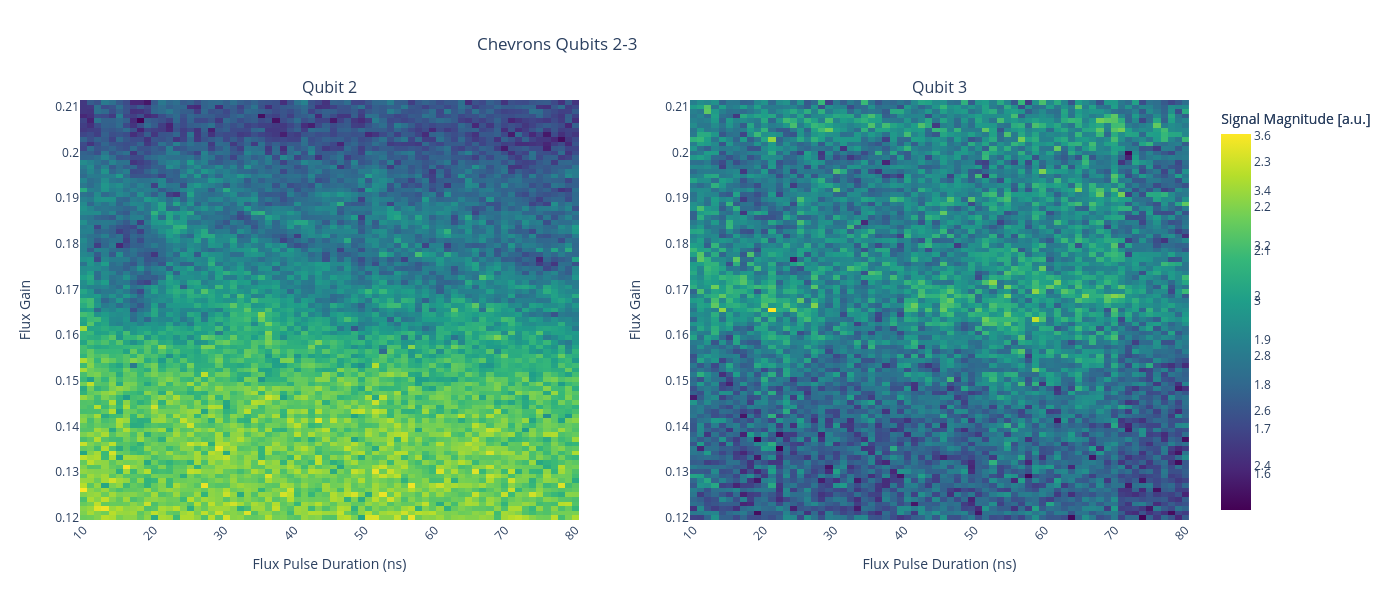

In [38]:
# Print results_r1,r2,r3,r4
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("Qubit 2", "Qubit 3"))
#fig.add_trace(go.Heatmap(z=r2, x=length_range, y=gain_range, colorscale='Viridis', colorbar=dict(title='Signal Magnitude [a.u.]')), row=1, col=1)
#fig.add_trace(go.Heatmap(z=r3, x=length_range, y=gain_range, colorscale='Viridis', colorbar=dict(title='Signal Magnitude [a.u.]')), row=1, col=2)       
fig.add_trace(go.Heatmap(z=np.transpose(r2), x=length_range, y=gain_range, colorscale='Viridis', colorbar=dict(title='Signal Magnitude [a.u.]')), row=1, col=1)
fig.add_trace(go.Heatmap(z=np.transpose(r3), x=length_range, y=gain_range, colorscale='Viridis', colorbar=dict(title='Signal Magnitude [a.u.]')), row=1, col=2)   
# Update x-axis and y-axis labels
fig.update_xaxes(title_text="Flux Pulse Duration (ns)",     
                 #range=[0, 120], 
                 tickangle=-45
                )
fig.update_yaxes(title_text="Flux Gain",     
                 #range=[0, 1], 
                )
fig.update_layout(title='Chevrons Qubits 2-3',                  
                  height = 600, width = 1800,
                  title_x= 0.4,
                )
fig.show()